In [1]:
# 导包
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import jieba

import collections
import os

In [2]:
def read_file_word2dict(filename):
    with open(filename, 'r') as f:
        dictionary = dict()
        for line in f.readlines():
            line = line.strip().split(' ')
            for word in line:
                if word not in dictionary:
                    dictionary[word] = len(dictionary) + 1
        return dictionary

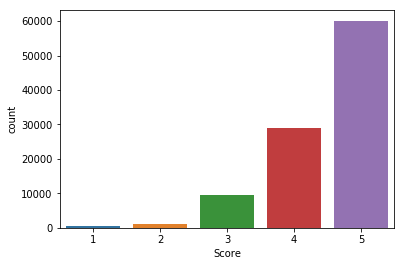

[5 4 3 2 1]
(100000, 3) (30000, 2)


,Id,Discuss,Score
0,201e8bf2-77a2-3a98-9fcf-4ce03914e712,好大的一个游乐公园，已经去了2次，但感觉还没有玩够似的！会有第三，第四次的,5
1,f4d51947-eac4-3005-9d3c-2f32d6068a2d,新中国成立也是在这举行，对我们中国人来说有些重要及深刻的意义！,4
2,74aa7ae4-03a4-394c-bee0-5702d3a3082a,庐山瀑布非常有名，也有非常多个瀑布，只是最好看的非三叠泉莫属，推荐一去,4
3,099661c2-4360-3c49-a2fe-8c783764f7db,个人觉得颐和园是北京最值的一起的地方，不过相比下门票也是最贵的，比起故宫的雄伟与气势磅礴，颐...,5
4,97ca672d-e558-3542-ba7b-ee719bba1bab,迪斯尼一日游,5


In [3]:
# 加载数据集
model_path = '../input/'

trainFile = model_path + 'train_first.csv'
testFile = model_path + 'predict_first.csv'

train = pd.read_csv(trainFile)
test = pd.read_csv(testFile)


sns.countplot(x = 'Score',data = train)
plt.show()

print(train['Score'].unique())  # 采取多分类？
print(train.shape, test.shape)


test['Score'] = -1
data = pd.concat([train, test])

data.head()

In [4]:
data_best = pd.read_csv(model_path + '/best feature/data.csv')
data_best.head()
del data_best['Score']

data = pd.merge(data, data_best, on = 'Id', how = 'left')

c:\users\demonsong\appdata\local\programs\python\python36\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (12,49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
# hancks 分词
train_word = pd.read_csv(model_path + 'train_word.csv')
test_word = pd.read_csv(model_path + 'predict_word.csv')
data_word = pd.concat([train_word, test_word])

# 群里siginicant word
significant_dictionary =  read_file_word2dict(model_path + 'significance.txt')
def contain(word, key):
    return 1 if key in word else 0

for _, key in enumerate(significant_dictionary.keys()):
    data_word['significant_key_{}'.format(_)] = data_word['words'].apply(lambda x : contain(x, key))

del data_word['words']
data = pd.merge(data, data_word, on = 'Id', how = 'left')

In [6]:
# 3 4 5 6 词特征
data_word_len = pd.read_csv(model_path + 'data_word_len_500.csv')
del data_word_len['Score']

data = pd.merge(data, data_word_len, on = 'Id', how = 'left')

In [7]:
del data['Discuss']
data.head()

,Id,Score,senti_snownlp,strLen,word_len_words,word_max_words,word_std_words,word_sum_words,word_last_words,word_first_words,...,word_len_feature_1680,word_len_feature_85,word_len_feature_1273,word_len_feature_875,word_len_feature_1762,word_len_feature_1263,word_len_feature_1463,word_len_feature_122,word_len_feature_55,word_len_feature_872
0,201e8bf2-77a2-3a98-9fcf-4ce03914e712,5,0.521543,37,26,921,220.427130,1891,6,0,...,0,0,0,0,0,0,0,0,0,0
1,f4d51947-eac4-3005-9d3c-2f32d6068a2d,4,0.996441,31,17,5550,1564.227333,15730,5550,536,...,0,0,0,0,0,0,0,0,0,0
2,74aa7ae4-03a4-394c-bee0-5702d3a3082a,4,0.449366,35,21,2712,650.413516,6738,721,0,...,0,0,0,0,0,0,0,0,0,0
3,099661c2-4360-3c49-a2fe-8c783764f7db,5,0.985191,61,34,8004,1569.917041,18911,0,0,...,0,0,0,0,0,1,0,0,0,0
4,97ca672d-e558-3542-ba7b-ee719bba1bab,5,0.972308,6,2,1315,485.000000,1660,1315,345,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# persist
data.to_csv(model_path + 'data.csv', index = False)
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 130000 entries, 0 to 129999
Columns: 1111 entries, Id to word_len_feature_872
dtypes: float64(366), int64(742), object(3)
memory usage: 1.1+ GB
None


In [9]:
# 划分数据
def split_data(data, label):
    data_classify_5 = data.copy()
    data_classify_5['Score'].ix[(data_classify_5['Score'] != label) & (data_classify_5['Score'] != -1)] = 0
    data_classify_5['Score'].ix[data_classify_5['Score'] == label] = 1
    data_classify_5.to_csv('../input/multi2binary/' + 'data_{}.csv'.format(label), index = False)
    print('done...')

for i in range(1, 6):
    split_data(data, i)

c:\users\demonsong\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.
c:\users\demonsong\appdata\local\programs\python\python36\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


done...
done...
done...
done...
done...
